# Process the mined puzzles


In [1]:
%load_ext autoreload
%autoreload 2

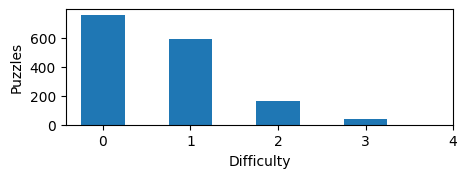

In [8]:
from modules.solve_sudodle_via_human_heuristics import score_puzzle_difficulty
from modules.parse_rust_results import parse_puzzles_from_txt
import matplotlib.pyplot as plt


def plot_difficulty_histogram(difficulties):
    fig, ax = plt.subplots(1, figsize=(5, 1.5))
    ax.hist(
        difficulties, bins=range(0, max(difficulties) + 1), align="left", rwidth=0.5
    )
    ax.set_xlabel("Difficulty")
    ax.set_ylabel("Puzzles")
    ax.set_xticks(range(0, max(difficulties) + 1))
    return fig, ax


puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s5.txt")
difficulties = [score_puzzle_difficulty(puzzle, 5) for puzzle in puzzles]

fig, ax = plot_difficulty_histogram(difficulties)
fig.savefig("outputs/5x5_difficulties.jpeg", bbox_inches="tight")


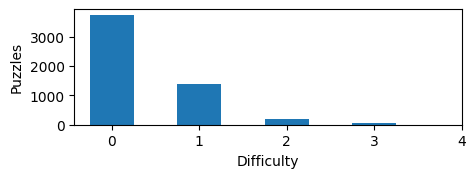

In [12]:
puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s5-p5.txt")
difficulties = [score_puzzle_difficulty(puzzle, 5) for puzzle in puzzles]
plot_difficulty_histogram(difficulties);


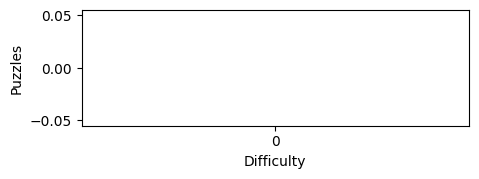

In [13]:
puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s6.txt")
difficulties = [score_puzzle_difficulty(puzzle, 6) for puzzle in puzzles]
plot_difficulty_histogram(difficulties);


  0%|          | 0/9360 [00:00<?, ?it/s]

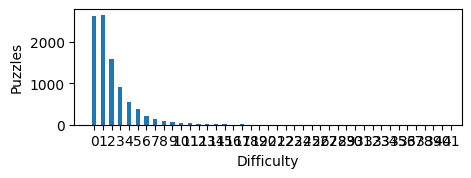

In [14]:
from tqdm.auto import tqdm

puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s6-p7.txt")
puzzles = puzzles[::10]
difficulties = [score_puzzle_difficulty(puzzle, 6) for puzzle in tqdm(puzzles)]
plot_difficulty_histogram(difficulties);


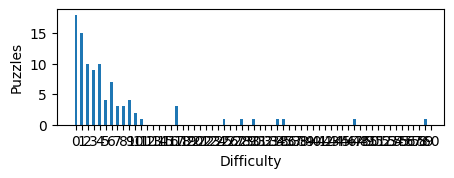

In [15]:
puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s7-p10-10M.txt")
difficulties = [score_puzzle_difficulty(puzzle, 7) for puzzle in puzzles]
plot_difficulty_histogram(difficulties);


In [19]:
from modules.sudodle_plotting import plot_puzzle
from pathlib import Path
import pandas

folder = Path("rust_puzzle_finder/outputs")


def compact_puzzle_string(puzzle, N):
    integers = [N * i + j for (i, j) in puzzle]
    character_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    return str(N) + "".join([character_list[n] for n in integers])


def compact_puzzles(file_name, N):
    puzzles = parse_puzzles_from_txt(folder / file_name, standardize_tiles=True)
    print(f"Found {len(puzzles)} puzzles in {file_name}")
    integers = [[N * i + j for (i, j) in tiles] for tiles in puzzles]
    character_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    characters_list = [
        ([str(N)] + [character_list[n] for n in tiles]) for tiles in integers
    ]
    return "\n".join(["".join(characters) for characters in sorted(characters_list)])


def difficulty_level(difficulty, difficulty_levels):
    for level in ["expert", "hard", "normal"]:
        if difficulty >= difficulty_levels[level]:
            return level
    raise ValueError(f"Difficulty {difficulty} is not in {difficulty_levels}")


records = []
for file_name, N, sampling_rate, difficulty_levels in [
    ("s4.txt", 4, 1, {"normal": 0, "hard": 1, "expert": 1}),
    ("s5.txt", 5, 1, {"normal": 0, "hard": 1, "expert": 6}),
    ("s5-p5.txt", 5, 10, {"normal": 0, "hard": 1, "expert": 6}),
    ("s6.txt", 6, 1, {"normal": 0, "hard": 2, "expert": 6}),
    ("s6-p7.txt", 6, 100, {"normal": 0, "hard": 2, "expert": 6}),
    ("s7-p10-10M.txt", 7, 1, {"normal": 0, "hard": 2, "expert": 10}),
]:
    puzzles = parse_puzzles_from_txt(folder / file_name, standardize_tiles=True)
    puzzles = puzzles[::sampling_rate]
    print("Processing", len(puzzles), "puzzles from", file_name)
    difficulties = [score_puzzle_difficulty(puzzle, N) for puzzle in puzzles]
    for puzzle, difficulty in tqdm(zip(puzzles, difficulties)):
        level = difficulty_level(difficulty, difficulty_levels)
        compact_puzzle = compact_puzzle_string(puzzle, N)
        target = Path("outputs") / "svgs" / f"{compact_puzzle}.svg"
        target.parent.mkdir(parents=True, exist_ok=True)
        ax = plot_puzzle(N=N, well_placed_tiles=puzzle)
        ax.figure.savefig(target, bbox_inches="tight")
        plt.close(ax.figure)
        records.append(
            {
                "compacted_puzzle": compact_puzzle,
                "level": level,
                "image_path": str(target),
                "difficulty": difficulty,
            }
        )

pandas.DataFrame(records).to_csv("outputs/puzzles.csv", index=False)

Processing 26 puzzles from s4.txt


0it [00:00, ?it/s]

Processing 1560 puzzles from s5.txt


0it [00:00, ?it/s]

Processing 541 puzzles from s5-p5.txt


0it [00:00, ?it/s]

Processing 57 puzzles from s6.txt


0it [00:00, ?it/s]

Processing 936 puzzles from s6-p7.txt


0it [00:00, ?it/s]

Processing 96 puzzles from s7-p10-10M.txt


0it [00:00, ?it/s]

In [20]:
df = pandas.read_csv("outputs/puzzles.csv")
df[["compacted_puzzle", "level"]].to_csv("../sudodle/public/puzzles.csv", index=False)